In [1]:
from __future__ import print_function, division
import sys
import os
import torch
import numpy as np
from typing import List, Tuple
from torch.utils.data import Dataset, DataLoader
import math
import torch
import torch.nn as nn
import torch.utils.data
from visualDet3D.utils.utils import alpha2theta_3d, theta2alpha_3d
from visualDet3D.data.kitti.kittidata import KittiData, KittiObj, KittiCalib
from visualDet3D.data.pipeline import build_augmentator
import os
import pickle
import numpy as np
from copy import deepcopy
from visualDet3D.networks.utils import BBox3dProjector
from visualDet3D.networks.utils.registry import DATASET_DICT
import sys
from matplotlib import pyplot as plt
from collections import namedtuple
from numpy.linalg import inv


# import sys
# sys.path.insert(0, "/home/lab530/KenYu/visualDet3D/visualDet3D/data/kitti/dataset/")
# from mono_dataset import KittiMonoDataset

ros_py_path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if sys.version_info > (3, 0) and ros_py_path in sys.path:
    #Python 3, compatible with a naive ros environment
    sys.path.remove(ros_py_path)
    import cv2
    sys.path.append(ros_py_path)
else:
    #Python 2
    import cv2

Obj_3d = namedtuple('Obj_3d', ('cx', 'cy', 'z', 'w', 'h', 'l', 'alpha'))


In [2]:
def compute_3Dbox(P2, obj): # This is copy from mltoolkit/3d_object_detection_visualization/viz3Dbox.py
    # Project (cx, cy, z) to (x_3d, y_3d, z_3d), TODO, this is a problem when uses right image
    tx, ty, tz = inv(P2[:, :3]) @ np.array([obj.cx*obj.z, obj.cy*obj.z, obj.z])

    # Convert alpha to rot_y
    theta = math.atan2(tz, tx)
    # rot_y = obj.alpha + theta
    rot_y = obj.alpha - theta + math.pi/2.0
    
    # Draw 3D Bounding Box
    R = np.array([[ np.cos(rot_y), 0, np.sin(rot_y)],
                  [ 0            , 1, 0            ],
                  [-np.sin(rot_y), 0, np.cos(rot_y)]])
    
    x_corners = [0, obj.l, obj.l, obj.l, obj.l, 0,     0,     0]  # -l/2
    y_corners = [0, 0,     obj.h, obj.h, 0,     0,     obj.h, obj.h]  # -h
    z_corners = [0, 0,     0,     obj.w, obj.w, obj.w, obj.w, 0]  # -w/2

    x_corners = [i - obj.l / 2 for i in x_corners]
    y_corners = [i - obj.h / 2 for i in y_corners]
    z_corners = [i - obj.w / 2 for i in z_corners]

    corners_3D = np.array([x_corners, y_corners, z_corners])
    corners_3D = R.dot(corners_3D)
    corners_3D += np.array([tx, ty, tz]).reshape((3, 1))

    corners_3D_1 = np.vstack((corners_3D, np.ones((corners_3D.shape[-1]))))
    corners_2D = P2.dot(corners_3D_1)
    corners_2D = corners_2D / corners_2D[2]
    corners_2D = corners_2D[:2]
    
    return corners_2D


class KittiMonoDataset(torch.utils.data.Dataset):
    def __init__(self, cfg, split='training'):
        super(KittiMonoDataset, self).__init__()
        preprocessed_path   = cfg.path.preprocessed_path
        obj_types           = cfg.obj_types
        is_train = (split == 'training')

        self.is_copy_paste = any(d['type_name'] == 'CopyPaste' for d in cfg.data.train_augmentation)
        
        imdb_file_path = os.path.join(preprocessed_path, split, 'imdb.pkl')
        self.imdb = pickle.load(open(imdb_file_path, 'rb')) # list of kittiData
        self.output_dict = {
                "calib": False,
                "image": True,
                "label": False,
                "velodyne": False,
                "depth": self.is_copy_paste,
            }
        if is_train:
            self.transform = build_augmentator(cfg.data.train_augmentation)
        else:
            self.transform = build_augmentator(cfg.data.test_augmentation)
        self.projector = BBox3dProjector()
        self.is_train = is_train
        self.obj_types = obj_types
        self.use_right_image = getattr(cfg.data, 'use_right_image', True)
        print(f"[mono_dataset.py] use_right_image = {self.use_right_image}")
        self.is_reproject = getattr(cfg.data, 'is_reproject', True) # if reproject 2d

    def _reproject(self, P2:np.ndarray, transformed_label:List[KittiObj]) -> Tuple[List[KittiObj], np.ndarray]:
        bbox3d_state = np.zeros([len(transformed_label), 7]) #[camera_x, camera_y, z, w, h, l, alpha]
        for obj in transformed_label:
            obj.alpha = theta2alpha_3d(obj.ry, obj.x, obj.z, P2)
        bbox3d_origin = torch.tensor([[obj.x, obj.y - 0.5 * obj.h, obj.z, obj.w, obj.h, obj.l, obj.alpha] for obj in transformed_label], dtype=torch.float32)
        abs_corner, homo_corner, _ = self.projector(bbox3d_origin, bbox3d_origin.new(P2))
        for i, obj in enumerate(transformed_label):
            extended_center = np.array([obj.x, obj.y - 0.5 * obj.h, obj.z, 1])[:, np.newaxis] #[4, 1]
            image_center = (P2 @ extended_center)[:, 0] #[3]
            image_center[0:2] /= image_center[2]
            bbox3d_state[i] = np.concatenate([image_center,[obj.w, obj.h, obj.l, obj.alpha]]) #[7]

        max_xy, _= homo_corner[:, :, 0:2].max(dim = 1)  # [N,2]
        min_xy, _= homo_corner[:, :, 0:2].min(dim = 1)  # [N,2]

        result = torch.cat([min_xy, max_xy], dim=-1) #[:, 4]

        bbox2d = result.cpu().numpy()

        if self.is_reproject: # Use 3d bbox and 2d bbox relation to reproject
            for i in range(len(transformed_label)):
                transformed_label[i].bbox_l = bbox2d[i, 0]
                transformed_label[i].bbox_t = bbox2d[i, 1]
                transformed_label[i].bbox_r = bbox2d[i, 2]
                transformed_label[i].bbox_b = bbox2d[i, 3]
        
        return transformed_label, bbox3d_state


    def __getitem__(self, index):
        kitti_data = self.imdb[index % len(self.imdb)]
        # The calib and label has been preloaded to minimize the time in each indexing
        if index >= len(self.imdb):
            kitti_data.output_dict = {
                "calib": True,
                "image": False,
                "image_3":True,
                "label": False,
                "velodyne": False,
                "depth": self.is_copy_paste,
            }
            calib, _, image, _, _, depth = kitti_data.read_data()
            calib.P2 = calib.P3 # a workaround to use P3 for right camera images. 3D bboxes are the same(cx, cy, z, w, h, l, alpha)
        else:
            kitti_data.output_dict = self.output_dict
            _, image, _, _, depth = kitti_data.read_data()
            calib = kitti_data.calib
        calib.image_shape = image.shape
        label = kitti_data.label # label: list of kittiObj
        label = []
        for obj in kitti_data.label:
            if obj.type in self.obj_types:
                label.append(obj)

        # label transformation happen here
        transformed_image, transformed_P2, transformed_label = self.transform(image, p2=deepcopy(calib.P2), labels=deepcopy(label), depth_map=depth)
        bbox3d_state = np.zeros([len(transformed_label), 7]) #[camera_x, camera_y, z, w, h, l, alpha]
        if len(transformed_label) > 0:
            transformed_label, bbox3d_state = self._reproject(transformed_P2, transformed_label)
        # print(f"transformed_label after _reproject = {(transformed_label[0].bbox_l, transformed_label[0].bbox_t, transformed_label[0].bbox_r, transformed_label[0].bbox_b)}")

        bbox2d = np.array([[obj.bbox_l, obj.bbox_t, obj.bbox_r, obj.bbox_b] for obj in transformed_label])

        loc_3d_ry = np.array( [[obj.x, obj.y, obj.z, obj.ry] for obj in transformed_label] )
        
        output_dict = {'calib': transformed_P2,
                       'image': transformed_image,
                       'label': [obj.type for obj in transformed_label], 
                       'bbox2d': bbox2d, #[N, 4] [x1, y1, x2, y2]
                       'bbox3d': bbox3d_state, 
                       'original_shape':image.shape,
                       'original_P':calib.P2.copy(),
                       'loc_3d_ry':loc_3d_ry,}
        return output_dict

    def __len__(self):
        if self.is_train and self.use_right_image:
            return len(self.imdb) * 2
        else:
            return len(self.imdb)

    @staticmethod
    def collate_fn(batch):
        rgb_images = np.array([item["image"] for item in batch])#[batch, H, W, 3]
        rgb_images = rgb_images.transpose([0, 3, 1, 2])

        calib     = [item["calib"]     for item in batch]
        label     = [item['label']     for item in batch]
        bbox2ds   = [item['bbox2d']    for item in batch]
        bbox3ds   = [item['bbox3d']    for item in batch]
        loc_3d_ry = [item['loc_3d_ry'] for item in batch]
        # This line will cause warning:
        # Creating a tensor from a list of numpy.ndarrays is extremely slow. 
        # Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.
        # add np.array() to avoid warning.
        return torch.from_numpy(rgb_images).float(), torch.tensor(np.array(calib)).float(), label, bbox2ds, bbox3ds, loc_3d_ry


In [3]:
# from visualDet3D.utils.utils import cfg_from_file

# NUM_IMG_SHOW = 10

# import sys
# sys.path.insert(0, "../kitti/")
# from util_kitti import init_img_plt, draw_2Dbox, kitti_label_file_parser, draw_corner_2D, draw_birdeyes, kitti_calib_file_parser
# from util_kitti import AVG_LENTH, KITTI_Object, compute_birdviewbox, load_tf_image, AVG_HEIGT

# cfg = cfg_from_file("config/data_augumentation/viz_da.py")
# dataset_train = KittiMonoDataset(cfg)
# dataloader_train = DataLoader(dataset_train, num_workers=cfg.data.num_workers,
#                                 batch_size=cfg.data.batch_size, collate_fn=dataset_train.collate_fn, shuffle=None, drop_last=True,
#                                 sampler=None)

# print(f"cfg.data.use_right_image = {cfg.data.use_right_image}")
# print(f"Number of training image = {len(dataloader_train)}")

# images_out = []
# for iter_num, data in enumerate(dataloader_train):
    
#     # print(f"data[0] = {data[0].shape}") # Image, [1, 3, 288, 1280]
#     # print(f"data[1] = {data[1].shape}") # Calib, [1, 3, 4]
#     # print(f"data[2] = {data[2]}") # Name of class, [['Car'], ...]
#     # print(f"data[3] = {data[3]}") # 2D bbox's label, [[644.7101 ,  85.14843, 762.30634, 195.32442], ..]
#     # print(f"data[4] = {data[4]}") # 3D boox's label, [[698.94255715, 131.42488171,  13.22274588,   1.73      ,
#     #   1.57      ,   4.15      ,   1.53982661]]

#     image = data[0][0]
#     P2 = data[1][0].numpy()
#     image = image.permute(1,2,0).to(torch.int).numpy()
#     for obj_idx in range(len(data[2][0])):
#         pass
#         # Draw 2D Bounding Box
#         x1, y1, x2, y2 = [int(i) for i in data[3][0][obj_idx]]
#         cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 255), 2)

#         # 3D Bounding Box
#         # The right image 3bbox looks bad, it's because P2 and 3d label don't change during transformation
#         # I think it's also why right image it's very helpful
#         # TODO The network have to learn two differnt angle of object and project them to the same value
#         cx, cy, cz, w, h, l, alpha  = data[4][0][obj_idx]                # Convert cx,cy,cz to x3d,y3d,z3d

#         # obj_3d = Obj_3d(cx, cy, cz, w, h, l, alpha)
#         # corners = compute_3Dbox(P2, obj_3d)
#         # cv2.circle(image, (int(cx), int(cy)), 3, (255, 0, 255), 3)
        

#         # # Draw 3D box
#         # for idx in [(0, 1), (1, 2), (2, 7), (7, 0), 
#         #             (3, 6), (3, 4), (4, 5), (5, 6),
#         #             (0, 5), (1, 4), (2, 3), (6, 7)]:
#         #     x1, y1 = int(corners[0][idx[0]]), int(corners[1][idx[0]])
#         #     x2, y2 = int(corners[0][idx[1]]), int(corners[1][idx[1]])
#         #     # cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2) 
    
#     images_out.append(image)
    
#     if len(images_out) >= NUM_IMG_SHOW : break

# print(f"{len(images_out)}")

# fig, ax = plt.subplots(int(NUM_IMG_SHOW/2), 2, figsize=(20, 12))
# # Adjust subplot spacing and margins
# fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.01, hspace=0.01)
# # Hide all axis
# [b.axis('off') for a in ax for b in a]
# # Show image
# [ax[int(i/2), i%2].imshow(images_out[i]) for i in range(NUM_IMG_SHOW)]


# Show image with BEV 

Loading instance pool from /home/lab530/KenYu/visualDet3D/exp_output/mixup/Mono3D/output/training/instance_pool.pkl
Loading instance pool from /home/lab530/KenYu/visualDet3D/exp_output/mixup/Mono3D/output/training/imgs_src.pkl
[mono_dataset.py] use_right_image = False
cfg.data.use_right_image = False
Number of training image = 3712


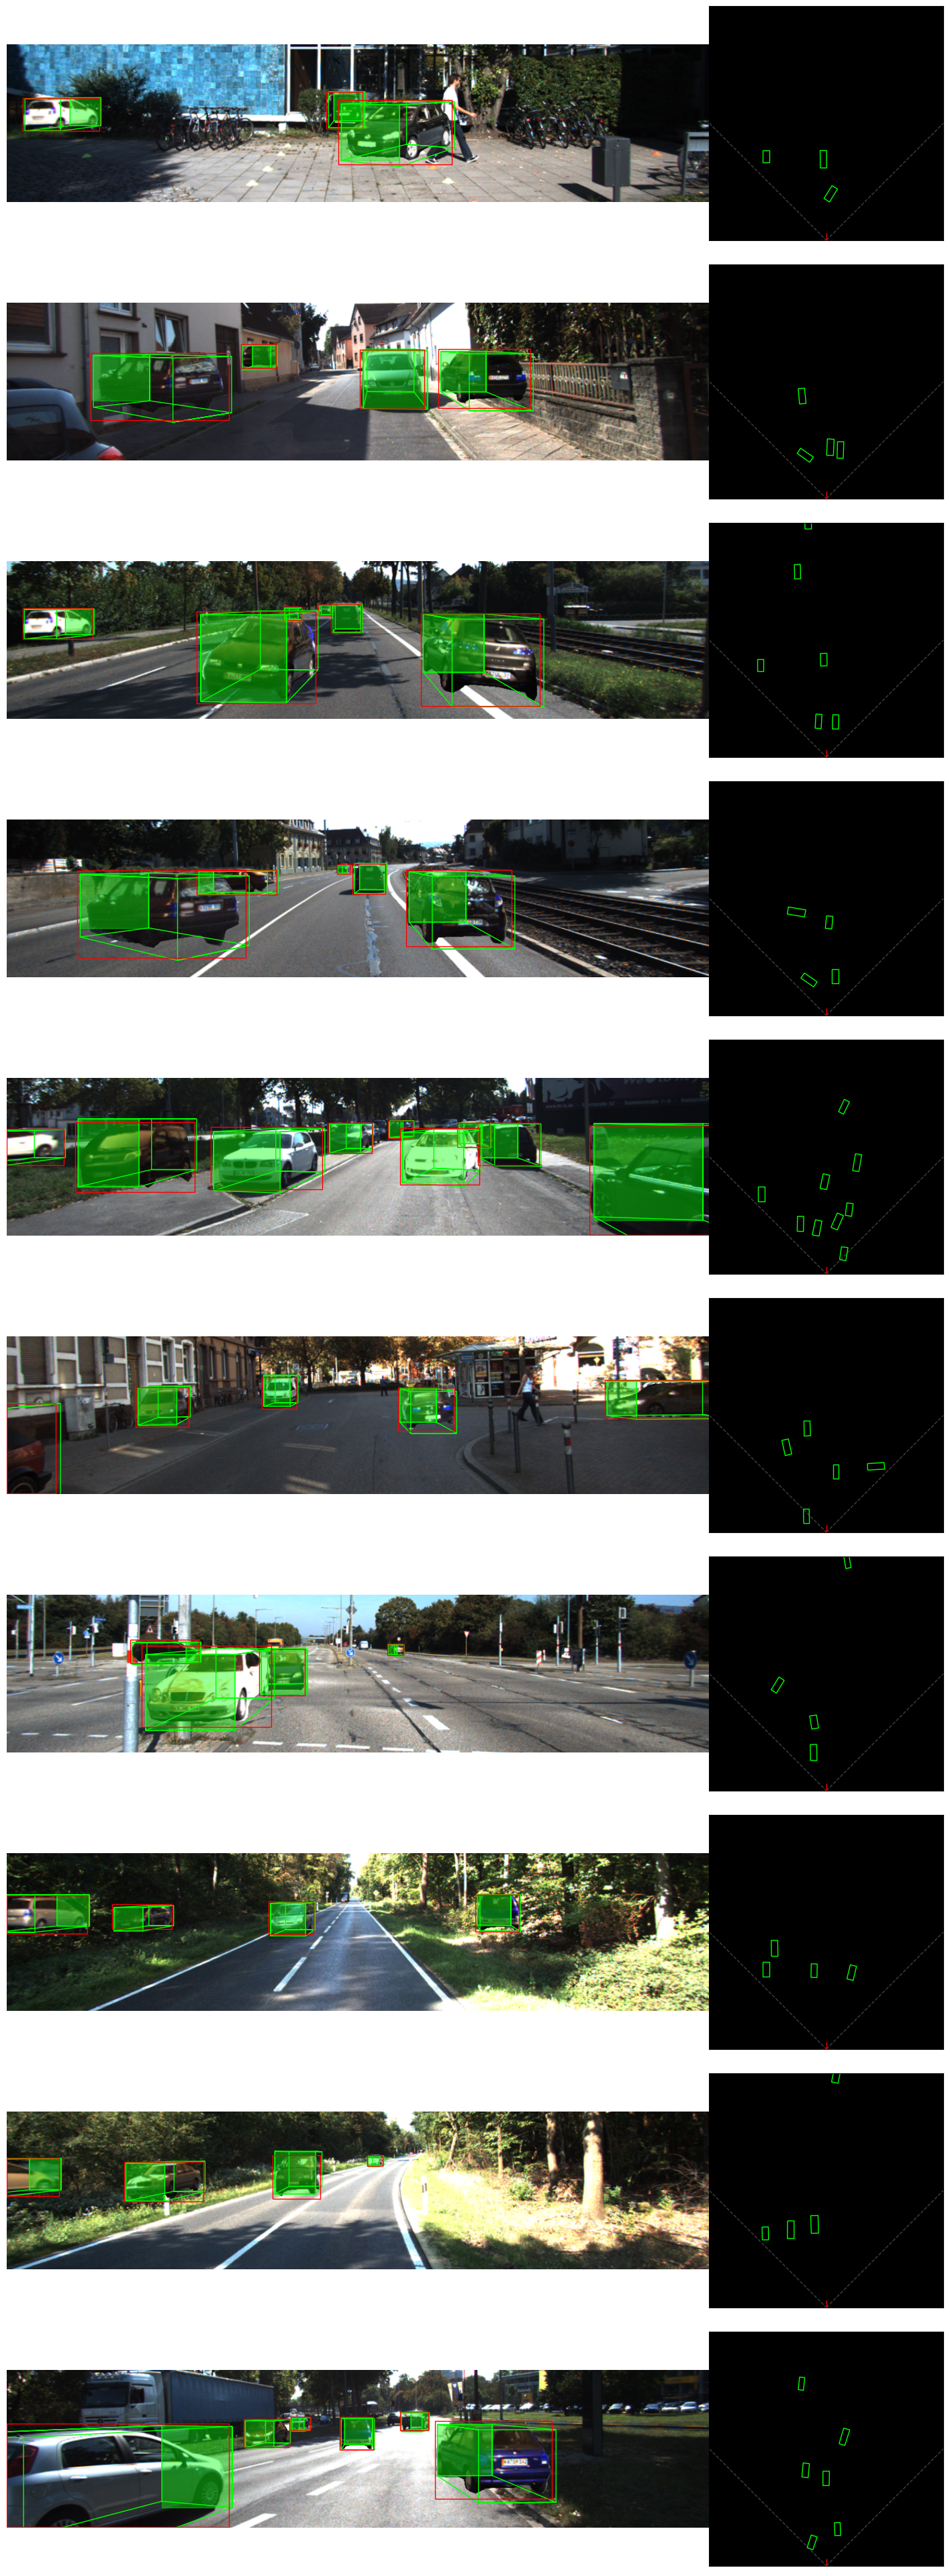

In [4]:
from visualDet3D.utils.utils import cfg_from_file
from math import pi, atan2

NUM_IMG_SHOW = 10

import sys
sys.path.insert(0, "../kitti/")
from util_kitti import init_img_plt, draw_2Dbox, kitti_label_file_parser, draw_corner_2D, draw_birdeyes, kitti_calib_file_parser
from util_kitti import AVG_LENTH, KITTI_Object, compute_birdviewbox, load_tf_image, AVG_HEIGT

cfg = cfg_from_file("config/data_augumentation/viz_da.py")
dataset_train = KittiMonoDataset(cfg)
dataloader_train = DataLoader(dataset_train, num_workers=cfg.data.num_workers,
                                batch_size=cfg.data.batch_size, collate_fn=dataset_train.collate_fn, shuffle=None, drop_last=True,
                                sampler=None)

print(f"cfg.data.use_right_image = {cfg.data.use_right_image}")
print(f"Number of training image = {len(dataloader_train)}")

imgs = []
objs = []
for iter_num, data in enumerate(dataloader_train):
    
    # print(f"data[0] = {data[0].shape}") # Image, [1, 3, 288, 1280]
    # print(f"data[1] = {data[1].shape}") # Calib, [1, 3, 4]
    # print(f"data[2] = {data[2]}") # Name of class, [['Car'], ...]
    # print(f"data[3] = {data[3]}") # 2D bbox's label, [[644.7101 ,  85.14843, 762.30634, 195.32442], ..]
    # print(f"data[4] = {data[4]}") # 3D boox's label, [[698.94255715, 131.42488171,  13.22274588,   1.73      ,
    #   1.57      ,   4.15      ,   1.53982661]]
    
    img = data[0][0]
    P2  = data[1][0].numpy()
    
    img = img.permute(1,2,0).to(torch.int).numpy()
    
    obj = []
    for obj_idx in range(len(data[2][0])):
        
        x1, y1, x2, y2              = data[3][0][obj_idx]
        cx, cy, cz, w, h, l, alpha  = data[4][0][obj_idx]
        
        # Convery cx,cy,cz to x3d,y3d,z3d
        loc_3d = np.linalg.inv(P2[:, :3]) @ np.array([[cx*cz], [cy*cz], [cz]])
        loc_3d[1, 0] += AVG_HEIGT / 2.0
        
        # Convert alpha to rot_y
        rot_y = alpha + pi/2 - atan2(loc_3d[2, 0], loc_3d[0, 0])
        if   rot_y >  pi: rot_y -= 2*pi # make alpha in [-pi, pi]
        elif rot_y < -pi: rot_y += 2*pi
        
        obj.append( KITTI_Object(f"Car NA NA {alpha} {x1} {y1} {x2} {y2} {h} {w} {l} {loc_3d[0, 0]} {loc_3d[1, 0]} {loc_3d[2, 0]} {rot_y} NA", P2) )
    
    imgs.append(img[..., ::-1])
    objs.append(obj)
    
    if len(imgs) >= NUM_IMG_SHOW : break

axs = init_img_plt(imgs)

for i in range(NUM_IMG_SHOW):
    for obj_idx in range(len(objs[i])):
        color = [0, 1, 0]
        
        # Draw bbox
        draw_corner_2D(axs[i][0], objs[i][obj_idx].corner_2D, color = color, is_draw_front = True)
        draw_2Dbox    (axs[i][0], (objs[i][obj_idx].xmin, objs[i][obj_idx].ymin, objs[i][obj_idx].xmax, objs[i][obj_idx].ymax), color = [1,0,0])
        draw_birdeyes (axs[i][1], objs[i][obj_idx], color = color, title = "123", is_print_confident = False)
